# Project 3: Sub-Reddit NLP Classification (The_Donald vs. Politics)

### Contents:
- [Data Collection](#Data-Collection)
    - [Import Packages](#Import-Packages)
    - [Data Pull](#Data-Pull)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [First Glances](#First-Glances)
    - [Subscriber Count](#Subscriber-Count)
    - [Numerics: Summary Statistics](#Numerics:-Summary-Statistics)
    - [Numerics: Correlations](#Numerics:-Correlations)
    - [Frequently Occuring Words](#Frequently-Occuring-Words)
- [Data Cleaning](#Data-Cleaning)
    - [Applying a Troll Filter](#Applying-a-Troll-Filter)
    - [Concatenating Data into Combined Data Frame](#Concatenating-Data-into-Combined-Data-Frame)
    - [Binarizing Target Variable `subreddit`](#Binarizing-Target-Variable-subreddit)
- [Further Visualizations: Word Clouds](#Further-Visualizations:-Word-Clouds)
    - [The_Donald](#The-Donald)
    - [Politics](#Politics)
    - [Aggregate](#Aggregate)
- [Preprocessing](#Preprocessing)
    - [Train Test Split](#Train-Test-Split)
- [Modeling](#Modeling)
    - [Determining Baseline Score](#Determining-Baseline-Score)
    - [Model 1: Random Forest](#Model-1:-Random-Forest)
    - [Model 2: Logistic Regression](#Model-2:-Logistic-Regression)
    - [Model 3: Support Vector Machine](#Model-3:-Support-Vector-Machine)
- [Supplemental Evaluation: Confusion Matrices](#Supplemental-Evaluation:-Confusion-Matrices)
    - [Confusion Matrix 1: Random Forest](#Confusion-Matrix-1:-Random-Forest)
    - [Confusion Matrix 2: Logistic Regression](#Confusion-Matrix-2:-Logistic-Regression)
    - [Confusion Matrix 3: Support Vector Machine](#Confusion-Matrix-3:-Support-Vector-Machine)
- [Conclusions and Evaluation](#Conclusions-and-Evaluation)

## Data Collection

### Import Packages

In [170]:
# Load data collection libraries
import requests
import time
import pandas as pd

# Load text processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Miscellaneous
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

# Load proprocessing/modeling/evaluation libraries
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn import svm
from sklearn.metrics import confusion_matrix

### Data Pull

The two subreddits we have chosen here are /r/The_Donald and /r/Politics

In [2]:
url_politics = "https://www.reddit.com/r/politics.json"
url_donald = "https://www.reddit.com/r/The_Donald.json"
headers = {"User-agent": 'boom-deva'}      # header to prevent 429 error

We'll only be able to pull 25 requests at once. Therefore to improve efficiency, we'll loop these pulls. To get the next consecutive 25 requests, we need to append the ID of our most recent last subreddit to the master URL.

We write a function to help us do this since we're going to apply this to more than 1 sub-Reddit.

In [3]:
# Function to pull subreddit posts
def get_subreddit(url, n_pulls):    

    # Create empty templates
    posts = []
    after = None

    # Create a loop that does max 25 requests per pull
    for pull_num in range(n_pulls):
        print("Pulling data attempted", pull_num+1,"time(s)")

        if after == None:
            new_url = url                 # base case
        else:
            new_url = url+"?after="+after # subsequent iterations

        res = requests.get(new_url, headers=headers)

        if res.status_code == 200:
            subreddit_json = res.json()                      # Pull JSON
            posts.extend(subreddit_json['data']['children']) # Get subreddit posts
            after = subreddit_json['data']['after']          # 'after' = ID of the last post in this iteration
        else:
            print("We've run into an error. The status code is:", res.status_code)
            break

        time.sleep(1)
        
    return(posts)

We are aiming for balanced samples, i.e. approximately the same number of posts for each subreddit. With 20 pulls, we should get approximately 500 posts for each subreddit.

In [4]:
# Pull Politics Subreddit posts
posts_politics = get_subreddit(url_politics, n_pulls = 20)

# Check length
print("----------------------------------------")
print("We have:", len(set([p['data']['name'] for p in posts_politics])), "posts in this subreddit")

Pulling data attempted 1 time(s)
Pulling data attempted 2 time(s)
Pulling data attempted 3 time(s)
Pulling data attempted 4 time(s)
Pulling data attempted 5 time(s)
Pulling data attempted 6 time(s)
Pulling data attempted 7 time(s)
Pulling data attempted 8 time(s)
Pulling data attempted 9 time(s)
Pulling data attempted 10 time(s)
Pulling data attempted 11 time(s)
Pulling data attempted 12 time(s)
Pulling data attempted 13 time(s)
Pulling data attempted 14 time(s)
Pulling data attempted 15 time(s)
Pulling data attempted 16 time(s)
Pulling data attempted 17 time(s)
Pulling data attempted 18 time(s)
Pulling data attempted 19 time(s)
Pulling data attempted 20 time(s)
----------------------------------------
We have: 502 posts in this subreddit


In [5]:
# Pull The Donald Subreddit posts
posts_donald = get_subreddit(url_donald, n_pulls = 20)

# Check length
print("----------------------------------------")
print("We have:", len(set([p['data']['name'] for p in posts_donald])), "posts in this subreddit")

Pulling data attempted 1 time(s)
Pulling data attempted 2 time(s)
Pulling data attempted 3 time(s)
Pulling data attempted 4 time(s)
Pulling data attempted 5 time(s)
Pulling data attempted 6 time(s)
Pulling data attempted 7 time(s)
Pulling data attempted 8 time(s)
Pulling data attempted 9 time(s)
Pulling data attempted 10 time(s)
Pulling data attempted 11 time(s)
Pulling data attempted 12 time(s)
Pulling data attempted 13 time(s)
Pulling data attempted 14 time(s)
Pulling data attempted 15 time(s)
Pulling data attempted 16 time(s)
Pulling data attempted 17 time(s)
Pulling data attempted 18 time(s)
Pulling data attempted 19 time(s)
Pulling data attempted 20 time(s)
----------------------------------------
We have: 501 posts in this subreddit


With our data all pulled, we can begin some exploratory data analysis.

## Exploratory Data Analysis

### First Glances

We now have a list of objects from each sub-Reddit. Let's take a look into one of these objects:

In [171]:
print("Object type is:", type(posts_donald[0]), "of length", len(posts_donald[0]))

Object type is: <class 'dict'> of length 2


So we're dealing with a dictionary with two keys:

In [172]:
posts_donald[0].keys()

dict_keys(['kind', 'data'])

The two keys of this dictionary are
- `kind`: which isn't very informative to us as we'll see
- `data`: a dictionary of a bunch of interesting features (title, number of comments, the author's username, etc.).

Let's take a peak into the first object in this list

In [173]:
# Peak into first object
posts_politics[0]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'politics',
  'selftext': "Thanks for joining us! This AMA is now closed. Thank you for your questions!! \n\nI'm Garrett Graff and I've been covering all things Donald Trump, Russia, and Robert Mueller for WIRED for the past two years, ever since the first word of Russia's attack on the 2016 election. While Mueller was FBI director, I wrote the only biography of his time at the FBI (THE THREAT MATRIX: The FBI At War) and spent dozens of hours with him. Now it's been three weeks of back-to-back-to-back-to-back bombshells by federal prosecutors and special counsel Robert Mueller. As 2018 winds down, Donald Trump faces a legal assault unlike anything previously seen by any president—at least 17 distinct court cases stemming from at least seven different sets of prosecutors and investigators. So let's discuss what is going on now that the year is rounding up and what to expect next year. \n\n\nProof: https://i.redd.it/t17gln3

While this is a lot of information to process, something we notice right away is that **there is some punctuation in the title** that we're not interested in. We'll need to clean that in the Data Cleaning section.

Also, note that this *first post is a pinned post* that that sub-Reddit administrator has decided to forced to the top, regardless of how long ago it was posted. These are *usually instructions or announcements*, so we're going to ignore the first post. Since our sample size is large, excluding the first to be safe is a relatively risk-free route.

### Subscriber Count

At the parent (sub-Reddit) level:

In [174]:
# Number of Subscribers (not post-specific)
politics_subscribers = posts_politics[1]['data']['subreddit_subscribers']
donald_subscribers = posts_donald[1]['data']['subreddit_subscribers']

print("Politics has",politics_subscribers,"subscribers")
print("The_Donald has",donald_subscribers,"subscribers")

Politics has 4380649 subscribers
The_Donald has 690286 subscribers


We're going to focus on the **title** to do natural language processing on since the actual body of many of these posts consist of memes in the form of images, which unfortunately is beyond our capacity to parse at this stage.

However, there are some numeric features we might want to explore first as some may be useful filtering criteria for cleaning our data before we actually start doing analysis:
- `num_comments`: the number of comments on the post, indicative of the amount of activity
- `score`: number of up-votes minus number of down-votes, similarly indicative of the amount of activity but also approval levels (i.e. negative scores may be a good indicator of "troll" posts
- `num_reports`: the number of reports filed agains the post for violating guidelines (good indicator or "troll" posts)

### Numerics: Summary Statistics

To make calculating processing more convenient, we'll need to convert convert the post dictionary to a dataframe and apply some quick cleaning to it (remove duplicates, replacing `None` with `0`)

In [175]:
# Function to extract relevant EDA statistics 
def posts_to_df(posts_list):
    
    # Create empty df template
    df = pd.DataFrame()
    
    # Loop through posts
    for post in posts_list:
        
        # Extract relevant features
        relevant = {'title': [post['data']['title']],
                    'num_comments': [post['data']['num_comments']],
                    'score': [post['data']['score']],
                    'num_reports': [post['data']['num_reports']],
                    'subreddit': [post['data']['subreddit']]}
        
        # Append to existing df
        to_append = pd.DataFrame(relevant)
        df = df.append(to_append, ignore_index=True)
        
    # Cleaning: replace None with 0 in the num_reports column
    df['num_reports'].fillna(0, inplace=True)
    
    # Cleaning: eliminate duplicate posts (if any)
    df[~df.duplicated()]
    return df

In [176]:
# Apply function to our raw post data
politics_eda_df  = posts_to_df(posts_list = posts_politics[1:])
donald_eda_df = posts_to_df(posts_list = posts_donald[1:])

In [177]:
# Take a look
politics_eda_df.head()

,title,num_comments,score,num_reports,subreddit
0,[Megathread] Defense Secretary Jim Mattis to S...,11080,35965,0,politics
1,Treasury Official Who Allegedly Leaked Trump A...,419,9870,0,politics
2,GOP candidate who drove 'deportation bus' indi...,261,10901,0,politics
3,James Mattis will retire as secretary of Defen...,2266,16171,0,politics
4,Schumer: House-passed border wall bill dead in...,713,4868,0,politics


Some summary statistics for **Politics**

In [178]:
politics_eda_df.describe()

,num_comments,score,num_reports
count,501.000000,501.000000,501.0
mean,186.552894,2283.638723,0.0
std,684.554512,5794.427161,0.0
min,1.000000,7.000000,0.0
25%,10.000000,61.000000,0.0
50%,25.000000,229.000000,0.0
75%,100.000000,1432.000000,0.0
max,11080.000000,54552.000000,0.0


No reported posts in this sample, and looks like every post has at least one comment. The activity (measured by `num_comments` and `score`) look pretty "big", but we'll need to compare it to something.

So let's now take a look at some summary statistics for **The_Donald**

In [179]:
donald_eda_df.describe()

,num_comments,score,num_reports
count,500.000000,500.000000,500.0
mean,38.436000,801.460000,0.0
std,120.505373,1449.931869,0.0
min,0.000000,4.000000,0.0
25%,3.000000,67.000000,0.0
50%,8.000000,164.500000,0.0
75%,24.000000,717.500000,0.0
max,1897.000000,10441.000000,0.0


No reported posts here either, but considerably less activity (lower mean comments, and mean score). However, this is expected as `The_Donald` has only around 25% the number of subscribers that `Politics` does.

Recall that in terms of sheer quantity, Politics has far more subscribers which explains why it has a higher average number of comments and score per post. But to determine if these posts are actually comparable, we decided to normalize those numbers by representing the **means as a % of total subscribers**:

In [180]:
# Reconciling Politics Mean and SD
100*politics_eda_df.describe().loc[["mean","std"],["num_comments", "score"]]/politics_subscribers

,num_comments,score
mean,0.004259,0.052130
std,0.015627,0.132273


In [181]:
# The_Donald Politics Mean and SD
100*donald_eda_df.describe().loc[["mean","std"],["num_comments", "score"]]/donald_subscribers

,num_comments,score
mean,0.005568,0.116105
std,0.017457,0.210048


After scaling these, we see the mean and standard deviation of the number of comments and scores are quite similar between the two subreddits (essentially of the same order of magnitude). This validates our choice of subreddits as being comparable enough to train and test our model on.

### Numerics: Correlations

Since we suspect that number of comments and score are both indicative of activity, we expect a relatively strong positive correlation between the two. Let's plot the two against each other and compute the correlation coefficient just to confirm:

Correlation is: 0.7343165676469722


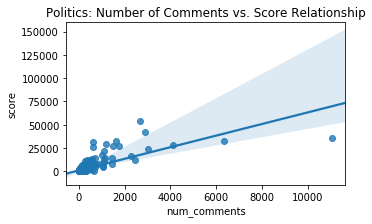

In [182]:
# Correlations for Politics
plt.figure(figsize=(5,3))
sns.regplot(politics_eda_df['num_comments'], politics_eda_df['score']);
plt.title("Politics: Number of Comments vs. Score Relationship")
print("Correlation is:", np.corrcoef(politics_eda_df['num_comments'], politics_eda_df['score'])[1,0])

Correlation is: 0.715452507564803


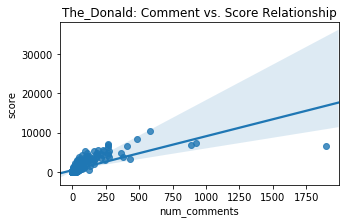

In [183]:
# Correlations for Donald
plt.figure(figsize=(5,3))
sns.regplot(donald_eda_df['num_comments'], donald_eda_df['score']);
plt.title("The_Donald: Comment vs. Score Relationship")
print("Correlation is:", np.corrcoef(donald_eda_df['num_comments'], donald_eda_df['score'])[1,0])

A correlation coefficient of 0.72 - 0.73 is a magnitude that is in line with our expectations. The negligible difference between the correlations coefficients shows consistency across the two subreddits, which again validates our choice to use these two subreddits to test our model.

Now that we've verified that our selected numerics are valid proxies for activity and therefore will make good filters for "troll" posts (outliers in this project), we can proceed to focusing on studying the words in the title.

### Frequently Occuring Words

Here we examine what the most used words in each sub-Reddit are. We'll begin with writing a helper function that makes use of `CountVectorizer` to help us get a word count after removing stopwords and punctuation.

In [184]:
# Function to count words
def word_counter(title_df):
    
    # Count Vectorize
    cvec = CountVectorizer(stop_words = 'english')

    # Transform the corpus
    X_text = cvec.fit_transform(title_df['title'])

    # Converts text to array form
    X_text = pd.DataFrame(X_text.toarray(), columns= cvec.get_feature_names())

    # See word counts
    word_counts = X_text.sum().sort_values(0, ascending=False)
    
    return word_counts

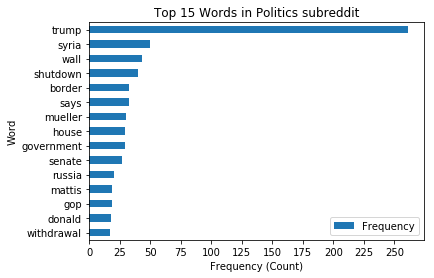

In [185]:
# Politics Top 15 Words
politics_wordcount = pd.DataFrame(word_counter(politics_eda_df), columns=["Frequency"])

# Visualize
politics_top15 = politics_wordcount.head(15)
politics_top15.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 15 Words in Politics subreddit")
plt.xlabel("Frequency (Count)")
plt.ylabel("Word")
plt.xticks(np.arange(0, 251, step=25))
plt.show()

In [186]:
# As a table
politics_top15

,Frequency
trump,261
syria,50
wall,43
shutdown,40
says,33
border,33
mueller,30
government,29
house,29
senate,27


It looks like Trump, Syria, and Wall are among the top most occurring words, with Trump appearing more than 5x as often as Syria. Now let's take a look at The Donald's:

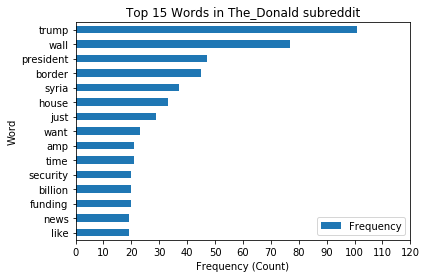

In [187]:
# The_Donald Top 15 Words
donald_wordcount = pd.DataFrame(word_counter(donald_eda_df), columns=["Frequency"])

# Visualize
donald_top15 = donald_wordcount.head(15)
donald_top15.sort_values('Frequency',ascending=True).plot(kind = "barh")
plt.title("Top 15 Words in The_Donald subreddit")
plt.xlabel("Frequency (Count)")
plt.ylabel("Word")
plt.xticks(np.arange(0, 121, step=10))
plt.show()

In [188]:
# As a table
donald_top15

,Frequency
trump,101
wall,77
president,47
border,45
syria,37
house,33
just,29
want,23
time,21
amp,21


Unsurprisingly, we see that the #1 most occuring word in both reddits is "Trump" though it appears twice as often in the `Politics` subreddit compared to `The_Donald`, despite keeping the number of posts in each sample fixed at 500. This is not too surprising though since `Politics` titles are typically longer and includes multiple sentences, like excerpts from articles. On the other hand, `The_Donald` titles are rather short colloquial statements (notice words like "just" and "like").

Something else we'll notice from the `The_Donald` subreddit is the word *"amp"* appears in the Top 15 words, however this isn't a word nor is it a stopword (which was excluded from our vectorizer). This forms part of **"&amp;"**, which is how the ampersand is read in JSON. Our vectorizer got rid of the punctuation (&) for us, however, the residual "amp" was not filtered out. We'll have to drop this column from our corpus in data cleaning below.

## Data Cleaning

While we did some quick cleanses above by getting rid of duplicates and filling missing numeric cells with 0's already, there is still some more sophisticted cleaning we'll have to do.

### Applying a Troll Filter 

We previously discussed using some of these numeric criteria could be useful as filter criteria, i.e. "troll filters".

Although in this particular sample we don't seem to have any negative scores or flagged posts, we write this filter function just in case anyone wishes to use this for other reddits.

Our rules on the criteria are:
- `num_reports > 0`: remove any posts that have been flagged at least once
- `score < 0`: remove any posts with a net negative score (keep 0 scorers, since a post may be new)

In [189]:
# Write troll filter function
def troll_filter(df):
    
    num_reports_mask = (df['num_reports'] == 0) # include only non-flagged posts
    score_mask = (df['score'] >= 0)             # include only non-negative scorers

    return df[num_reports_mask & score_mask]

In [190]:
# Apply filter
politics_eda_df = troll_filter(politics_eda_df)
donald_eda_df = troll_filter(donald_eda_df)

### Concatenating Data into Combined Data Frame

We now go back to focusing on just the `title` and `subreddit`, so let's combine just those two columns for both our subreddits

In [191]:
# Concatenate two subreddit dataframes into one
titles_df = pd.concat([politics_eda_df[['title','subreddit']], donald_eda_df[['title', 'subreddit']]], axis = 0)

In [192]:
# Deal with "&amp" cases
titles_df['title'] = titles_df['title'].map(lambda cell: cell.replace("&amp;","&"))

### Binarizing Target Variable `subreddit`

To prepare the data for preprocessing, we'll need to convert our target variable to a binary variable.

In [193]:
# Turn subreddit into a dummy column (1 = The_Donald, 0 = Politics)
titles_df['subreddit'] = np.where(titles_df['subreddit'] == "The_Donald",1,0)

In [194]:
# Check it out
titles_df.iloc[[1,2,-2,-1],]

,title,subreddit
1,Treasury Official Who Allegedly Leaked Trump A...,0
2,GOP candidate who drove 'deportation bus' indi...,0
498,DHS Sec Nielsen says migrants entering US ille...,1
499,He’s a Border (Wall) Collie today,1


In [195]:
# Save to .csv for reference
titles_df.to_csv("./cleaned_data/subreddit_titles.csv")

## Further Visualizations: Word Clouds

We can create some nice word clouds now that we've cleaned the data!

In [196]:
# Function to generate wordcloud for a given list of text
def make_wordcloud(text_list):
    # Aggregate titles
    text = " ".join(title for title in text_list)

    # Instantiate Word Cloud
    wc = WordCloud(stopwords = stopwords.words('english'),  # exclude stop words
                          max_font_size=72,                 # control biggest font size
                          max_words=150,                    # set how many words will show up
                          background_color="white")         # fix background color 
    
    # 'Fit' Word Cloud to text
    wordcloud = wc.generate(text)

    # Plot
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis("off");
    plt.show();

### The_Donald

The Donald Word Cloud


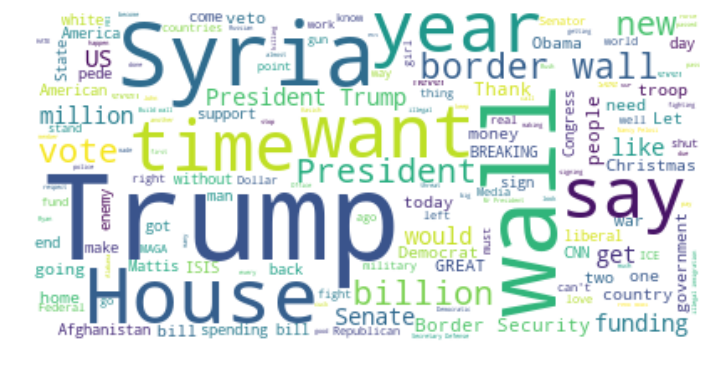

In [197]:
# Word Cloud for The_Donald
donald_titles = titles_df[titles_df['subreddit']==1]['title']
print("The Donald Word Cloud")
donald_wc = make_wordcloud(donald_titles);

# Save to image folder
# wordcloud.to_file("wordclouds/Donald_WC.png")

### Politics

Politics Word Cloud


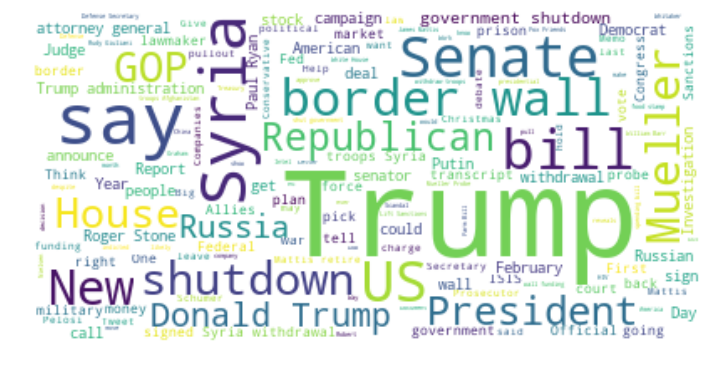

In [198]:
# Word Cloud for Politics
politics_titles = titles_df[titles_df['subreddit']==0]['title']
print("Politics Word Cloud")
politics_wc = make_wordcloud(politics_titles);

# Save to image folder
# politics_wc.to_file("wordclouds/Politics_WC.png")

### Aggregate
*(i.e. combining all posts for both /r/The_Donald and /r/Politics)*

Aggregate Word Cloud


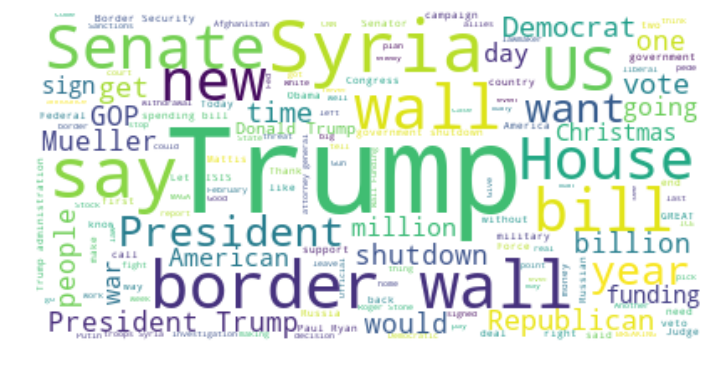

In [199]:
# Word Cloud for Aggregate
all_titles = titles_df['title']
print("Aggregate Word Cloud")
all_wc = make_wordcloud(all_titles);

# Save to image folder
# all_wc.to_file("wordclouds/Aggregate_WC.png")

## Preprocessing

### Train Test Split

With all the data now cleaned, we can prepare for modeling by applying a 70-30 train-test split.

In [200]:
# Set X and y
X = titles_df['title']
y = titles_df['subreddit']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

## Modeling and Evaluation

We'll be running a few classification models so this function will help automate the fit and scoring process.

*(Note that we've integrated word vectorization into the modeling process using Pipelines)*

In [201]:
# Function to automate fit and reporting process
def eval_model(pipe, grid_params):
    
    # Perform Grid Search
    gs = GridSearchCV(pipe, grid_params, cv=5, scoring='accuracy', verbose = 1, n_jobs=1)
    results = gs.fit(X_train, y_train)

    # Get best params
    vectorizer_params = results.best_estimator_.steps[0][1].get_params()
    model_params = results.best_estimator_.steps[1][1].get_params()

    # Get score
    train_score = results.best_score_
    print('Best TRAIN accuracy: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST set accuracy: {:.4f}'.format(test_score))

    print("----------------------------------------")
    
    return results, train_score, test_score, vectorizer_params, model_params

### Determining Baseline Score

The classification metric we will be using to measure the strength of our model is Accuracy since we’re only concerned about whether a post was categorized correctly or not. We do not care about distinguishing between false positives or false negatives. For completeness though, we’ve included the calculation of the other matrix along with the confusion matrices as a supplement in a section below.

The Baseline Accuracy is the case when we predict the majority class for all observations.

In [202]:
y_test.value_counts(normalize=True)

0    0.501661
1    0.498339
Name: subreddit, dtype: float64

Though we intended the sample sizes to be exactly 500 posts for each sub-Reddit, the data pull gave us 1-2 extra posts but the data set is still balanced for the most part. However, because of the slight difference, the majority class ended up being `y = 0` (`Politics`), which is what the baseline accuracy will be based off of.

In other words, given any post, we would predict that it belongs to the `Politics` subreddit everytime. Therefore, the baseline accuracy is **0.5017** or **50.17%**

### Model 1: Random Forest

In [203]:
%%time
# Define Pipeline
pipe_rf = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                       ('model', RandomForestClassifier())
                      ])

# Construct Grid Parameters
grid_params_rf = {"vectorizer__max_features": [2000, 3000, 4000],
                  "vectorizer__ngram_range":  [(1,1), (1,2)],
                  "vectorizer__norm":         ['l1', 'l2'],
                  "vectorizer__stop_words":   ['english'],
                  "model__n_estimators":      [15, 20, 25],
                  "model__max_depth":         [15, 20, 25],
                  "model__min_samples_leaf":  [1],
                  "model__criterion":         ['gini'],
                  "model__random_state":      [42]
              }

# Run reporting function with pipe and grid
results_rf, train_score_rf, test_score_rf, tfdif_params_rf, rf_params = eval_model(pipe_rf, grid_params_rf)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_rf))
print('Optimal Model params: n_estimators={n_estimators}, max_depth={max_depth} '.format(**rf_params))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.9min finished


Best TRAIN accuracy: 0.7586
Best TEST set accuracy: 0.7409
----------------------------------------
Optimal Vectorizer params: max_features=3000, ngram_range=(1, 1), norm=l2 
Optimal Model params: n_estimators=25, max_depth=25 
Wall time: 2min 53s


*Key Insights:*
- Decent performance under the Random Forest classifier given an accuracy score of 76%, which exceeds the baseline score by more than 1.5x.
- There does not seem to be any overfitting here since the testing set's accuracy score is 0.22% higher than the training set's.
- Seeing how close the training and testing accuracy scores are to each other suggests that our model's performance is consistent when applied to unseen data.

### Model 2: Logistic Regression

In [204]:
%%time
# Define Pipeline
pipe_logit = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                          ('model', LogisticRegression())
                         ])

# Construct Grid Parameters
grid_params_logit = {"vectorizer__max_features": [2500, 3000, 3500],
                     "vectorizer__ngram_range":  [(1,1), (1,2)],
                     "vectorizer__norm":         ['l1', 'l2'],
                     "vectorizer__stop_words":   ['english'],
                     "model__penalty":           ['l1', 'l2'],
                     "model__C":                 [3.0, 10.0, 100.0],
                     "model__tol":               [0.001],
                     "model__random_state":      [42]      
              }

# Run reporting function with pipe and grid
results_logit, train_score_logit, test_score_logit, tfdif_params_logit, logit_params = eval_model(pipe_logit, grid_params_logit)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_logit))
print('Optimal Model params: penalty={penalty}, C={C} '.format(**logit_params))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best TRAIN accuracy: 0.8029
Best TEST set accuracy: 0.7940
----------------------------------------
Optimal Vectorizer params: max_features=2500, ngram_range=(1, 1), norm=l1 
Optimal Model params: penalty=l2, C=10.0 
Wall time: 1min 17s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.3min finished


*Key Insights*:
- The Logistic Regression did better than the Random Forest Classifier since both Training and Testing accuracy scores were higher.
- However, the testing set's accuracy score is lower than the training set's which may suggest a very small degree of overfitting.

### Model 3: Support Vector Machine 

In [205]:
%%time
# Define Pipeline
pipe_svm = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                          ('model', svm.SVC())
                         ])

# Construct Grid Parameters
grid_params_svm = {"vectorizer__max_features":   [2000, 3000, 4000],
                     "vectorizer__ngram_range":  [(1,1),(1,2)],
                     "vectorizer__norm":         ['l1'],
                     "vectorizer__stop_words":   ['english'],
                     "model__C":                 [1.0, 10.0, 100.0],
                     "model__kernel":            ['rbf', 'linear'],
                     "model__gamma":             ['auto', 0.0001, 0.001] 
                  }

# Run reporting function with pipe and grid
results_svm, train_score_svm, test_score_svm, tfdif_params_svm, svm_params = eval_model(pipe_svm, grid_params_svm)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_svm))
print('Optimal Model params: C={C}, kernel={kernel}, gamma={gamma} '.format(**svm_params))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best TRAIN accuracy: 0.7986
Best TEST set accuracy: 0.8073
----------------------------------------
Optimal Vectorizer params: max_features=3000, ngram_range=(1, 1), norm=l1 
Optimal Model params: C=10.0, kernel=linear, gamma=auto 
Wall time: 3min 55s


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.9min finished


*Key Insights*:
- The SVM gives the highest testing accuracy (80.73%) out of all three models, though the training set performed slightly worse than the Logistic Regression
- Again no overfitting is evident here since the test accuracy score is actually 0.87% higher than the training score, which again shows consistency.

## Supplemental Evaluation: Confusion Matrices

While Accuracy is the only metric we should really be concerned about in this case, we can still break the score down to see how many values were correctly/incorrectly predicted using a Confusion Matrix

In [206]:
# Function to compute confusion matrix
def conf_matrix(model_results, X_test, y_test):
    y_hat    = model_results.predict(X_test)         # get predictions
    cm = confusion_matrix(y_test, y_hat)     # get confusion matrix data
    tn, fp, fn, tp = cm.ravel()              # extract elements of confusion matrix
    
    # Convert Confusion Matrix to DataFrame
    cm_df = pd.DataFrame(cm,
                         columns = ['Predict Politics (y=0)','Predict The_Donald (y=1)'],
                         index = ['Actual Politics (y=0)', 'Actual The_Donald (y=1)'])
    return cm_df

For completeness, the other classification metrics have also been included

In [207]:
# Function to compute all classification metrics
def eval_metric(confusion):
    sensitivity = confusion.loc['Actual The_Donald (y=1)','Predict The_Donald (y=1)']/sum(confusion.loc['Actual The_Donald (y=1)',])
    specificity = confusion.loc['Actual Politics (y=0)','Predict Politics (y=0)']/sum(confusion.loc['Actual Politics (y=0)',])
    accuracy = (confusion.loc['Actual The_Donald (y=1)','Predict The_Donald (y=1)'] 
                + confusion.loc['Actual Politics (y=0)','Predict Politics (y=0)'])/confusion.values.sum()
    precision = confusion.loc['Actual The_Donald (y=1)','Predict The_Donald (y=1)']/sum(confusion['Predict The_Donald (y=1)'])
    return {"accuracy": np.round(accuracy,4),
            "sensitivity": np.round(sensitivity,4),
            "specificity": np.round(specificity,4),
            "precision": np.round(precision,4)}

### Model 1: Random Forest

In [208]:
# Random Forest
rf_cf = conf_matrix(results_rf, X_test, y_test)
print(eval_metric(rf_cf))
rf_cf

{'accuracy': 0.7409, 'sensitivity': 0.8467, 'specificity': 0.6358, 'precision': 0.6978}


,Predict Politics (y=0),Predict The_Donald (y=1)
Actual Politics (y=0),96,55
Actual The_Donald (y=1),23,127


So out of the 301 testing posts, we see 96+127 = **223 posts were correctly classified**, while 23+55= **78 posts were misclassified** under Random Forest.

### Confusion Matrix 2: Logistic Regression

In [209]:
logit_cf = conf_matrix(results_logit, X_test, y_test)
print(eval_metric(logit_cf))
logit_cf

{'accuracy': 0.794, 'sensitivity': 0.78, 'specificity': 0.8079, 'precision': 0.8014}


,Predict Politics (y=0),Predict The_Donald (y=1)
Actual Politics (y=0),122,29
Actual The_Donald (y=1),33,117


So out of the 301 testing posts, we see 122+117 = **239 posts were correctly classified**, while 33+29= **62 posts were misclassified** under the Logistic Regression.

### Confusion Matrix 3: Support Vector Machine

In [210]:
svm_cf = conf_matrix(results_svm, X_test, y_test)
print(eval_metric(svm_cf))
svm_cf

{'accuracy': 0.8073, 'sensitivity': 0.7867, 'specificity': 0.8278, 'precision': 0.8194}


,Predict Politics (y=0),Predict The_Donald (y=1)
Actual Politics (y=0),125,26
Actual The_Donald (y=1),32,118


So out of the 301 testing posts, we see 125+116 = **241 posts were correctly classified**, while 34+26= **60 posts were misclassified** under SVM.

## Conclusion and Recommendations

All three models (Random Forest, Logistic Regression, Support Vector Machine) exceed the baseline accuracy of 50.1% by at least 1.5x as all models performed with an accuracy greater than 75%, demonstrating strong ability to classify at least 3 in 4 posts into the correct subreddit. However, the clear winner was the **Support Vector Machine (SVM) model, which was able to correctly 4 in 5 posts**. Therefore, this is the model we would recommend Reddit administrators to implement to help them classify buggy posts that have lost their subreddit tags.

Unfortunately, this model is not without limitations. While this model is good in practice, Reddit administrators do need to be aware that they still need to manually review the 1 in 5 posts that are misclassified by the SVM model. The model can likely be further fine-tuned to improve accuracy, however the nature of SVM makes the optimization process highly computationally intensive.

Another limitation of not just the SVM model but any model implemented for this purpose is that the nature of the subreddits may change over time. For example, in the case of /r/Politics vs /r/The_Donald, we saw that the word "Trump" is the most frequently occurring word in both subreddits. However, in a political regime where Donald Trump ceases to be relevant (either because of impeachment or the end of his term in 2020), we would expect to see a divergence in the most common words in each subreddit and key differentiating factors. In today's posts, we saw that colloquialisms (e.g. "like", "just", "billions!") were words that distinguished /r/The_Donald from /r/Politics; however, in a future where Trump is no longer president, words such as the new president's name, his cabinet members' names, and words topical to his/her policies and actions would serve to differentiate /r/Politics from /r/The_Donald.

However for the remainder of the current political regime, we can expect our model to perform consistently at the same level of accuracy on new posts as it has done on our testing set here.

Further improvements for the model include:
- Addressing the limitation of using single words as our splitting criteria: to reduce variance in our model, could we consider grouping synonyms together into a single feature
- Paying more attention to capitalization: while CountVectorizer and TfidfVectorizer made everything lower case to prevent the distinction of identical words like "Wall" vs. "wall", it may be important to consider words that are *all* caps as separate features since all caps, which typically represents shouting, sends an emotional signal. Such a signal is expected to be rather common in /r/The_Donald posts, but not in posts from a more formal subreddit like /r/Politics. 